# Titanic Prediction

Ok Let's take a look to understand one thing, you take the train and test and generate a model to submit to kaggle
the problem is that you can't test the real accuracy, because you don't have a y_true, one way to know 
if you get the train file and split that and create a validation when you model get the good performance than
you get the test file and submit

In [996]:
# !pip install imblearn
# !pip install scikit-plot
# this package don't got with anaconda, than, I installed.
# !pip install lightgbm
# !pip install scikit-optimize

In [997]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from skopt import dummy_minimize, gp_minimize
from skopt.plots import plot_convergence

from sklearn.metrics import mean_squared_log_error, f1_score, precision_score
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
import scikitplot as skplt

from sklearn import feature_selection

%matplotlib inline

In [998]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

Distribution of Data

# Data Exploration
#### Understanding the data and your means

In [999]:
df_train[['Age', 'Fare', 'Sex', "Pclass", "Embarked", "Survived"]].tail(15)
# observe the Embarked there are more survived people in C and died in S, are there a correlation? 
# the same comparation I ask you for Pclass = 1 more survived and 3 and 2 more died, are there a correlation?

,Age,Fare,Sex,Pclass,Embarked,Survived
876,20.0,9.8458,male,3,S,0
877,19.0,7.8958,male,3,S,0
878,NaN,7.8958,male,3,S,0
879,56.0,83.1583,female,1,C,1
880,25.0,26.0000,female,2,S,1
881,33.0,7.8958,male,3,S,0
882,22.0,10.5167,female,3,S,0
883,28.0,10.5000,male,2,S,0
884,25.0,7.0500,male,3,S,0
885,39.0,29.1250,female,3,Q,0


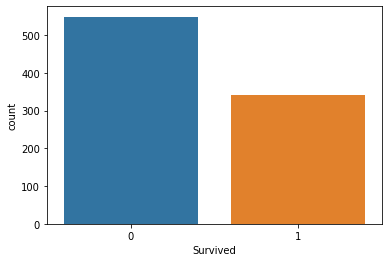

In [1000]:
sns.countplot(df_train['Survived']) # more people died than survived

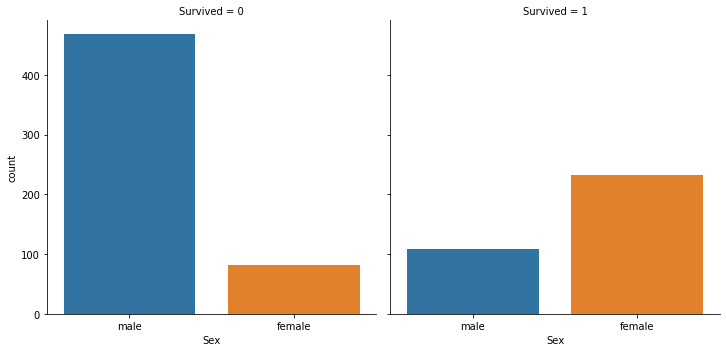

In [1001]:
sns.catplot(data=df_train.drop('PassengerId', axis=1), col='Survived', x='Sex', kind='count')
# more male died and more female survived, the doubt about the women and child first is real

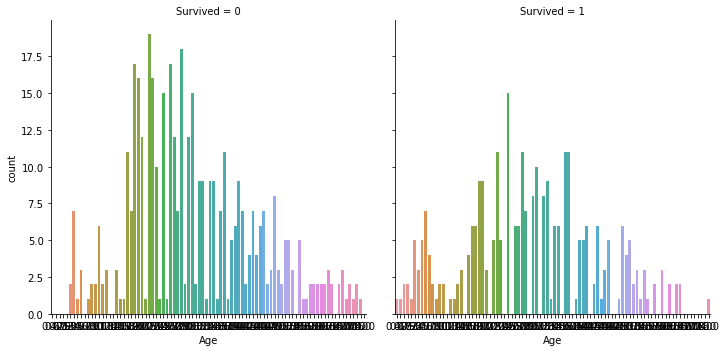

In [1002]:
# and the Age is when the younger more survived? let's see
sns.catplot(data=df_train, x='Age', col='Survived', kind='count')
# see? a baby survived more, but the midle age died more, and old people died more
# observe that has a specific ages there are more survived, in this case you can divided the age to try.

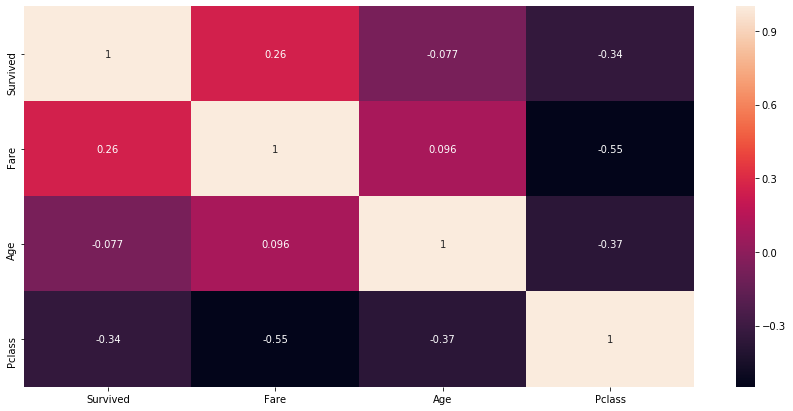

In [1003]:
# are there Fare, Sex, Embarked more correlation with Survived?
plt.figure(figsize=(15,7))
sns.heatmap(df_train[['Survived', 'Fare', 'Age', 'Pclass', 'Sex', 'Embarked']].corr(), annot=True)

In [1004]:
df_train[['Survived', 'Fare', 'Age', 'Pclass', 'Sex', 'Embarked']].info() # Sex and Embarked are "Object" = string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Survived    891 non-null int64
Fare        891 non-null float64
Age         714 non-null float64
Pclass      891 non-null int64
Sex         891 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 41.8+ KB


# Pre-Processing
#### Data for train "features"

In [1005]:
train = pd.DataFrame() # creating a new dataframe structure
train['survived'] = df_train['Survived'].copy()
train['fare'] = df_train['Fare'].copy()
train['pclass'] = df_train['Pclass'].copy()
train['age'] = df_train['Age'].fillna(df_train['Age'].median()) 
dum_emb = pd.get_dummies(df_train['Embarked']).fillna('S') # transform string in number and divided in new columns
train = pd.concat([train, dum_emb], axis=1)

# You can get divided dummy from pclass, creat news columns
dum_pclass = pd.get_dummies(train['pclass'], prefix='class')
train = pd.concat([train, dum_pclass], axis=1)
#train.drop('pclass', axis=1, inplace=True)
train['sex'] = df_train['Sex'].map({'male':0, 'female':1})

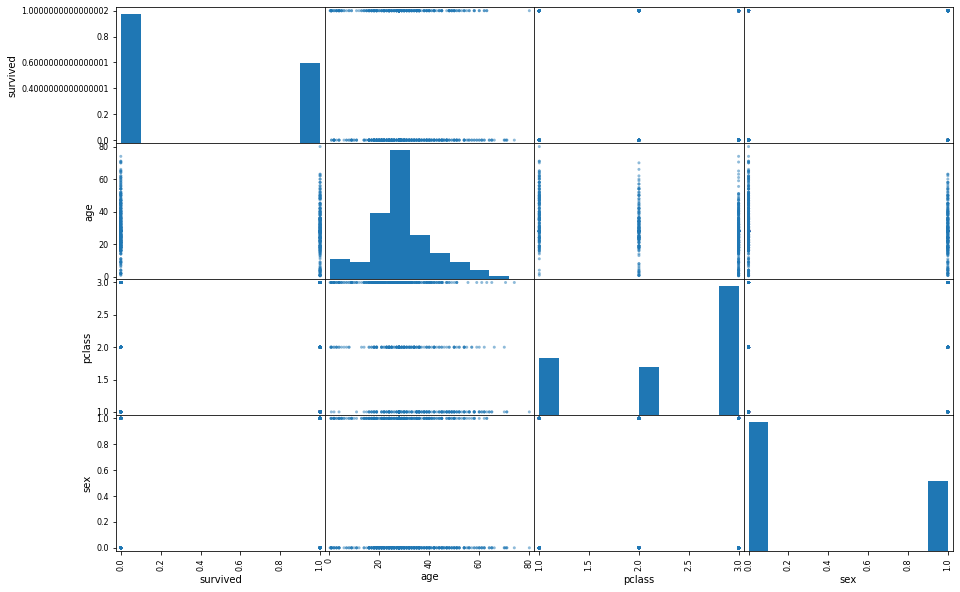

In [1006]:
pd.plotting.scatter_matrix(train[["survived","age", "pclass", "sex"]], figsize=(15,10))
plt.show()
# this code above, it's show that not is normal distribution, and that pclass 1 has less kids and more old people
# pclass = 2 there are more midle age, pclass=3 there are more kids an lessa old people
# than survived more kids, died more old

In [1007]:
# I tried get dummies from Fare, but creat a lot of columns, and the score is not so good, than I created a slices
# of values until 25, 50, 75 and 100, it's mean I clustered in four clusters.

#clustering the values of fare in quartis
fare_25 = train.fare[train.fare < 7.92]
fare_50 = train.fare[(train['fare'] >= 7.92) & (train['fare'] < 14.46)]
fare_75 = train.fare[(train['fare'] >= 14.46) & (train['fare'] < 31)]
fare_100 = train.fare[train.fare > 31]

# name of features
fare_25.name, fare_50.name = 'fare_25', 'fare_50'
fare_75.name, fare_100.name = 'fare_75', 'fare_100'

# concat the series clustered with dataframe 'train'
train = pd.concat([train, fare_25], axis=1).fillna(0)
train = pd.concat([train, fare_50], axis=1).fillna(0)
train = pd.concat([train, fare_75], axis=1).fillna(0)
train = pd.concat([train, fare_100], axis=1).fillna(0)

train.shape, train.columns

((891, 15),
 Index(['survived', 'fare', 'pclass', 'age', 'C', 'Q', 'S', 'class_1',
        'class_2', 'class_3', 'sex', 'fare_25', 'fare_50', 'fare_75',
        'fare_100'],
       dtype='object'))

In [1008]:
# clustered ages in three parts
age_1 = train.age[train['age'] < 15]
age_2 = train.age[(train['age'] > 14) & (train['age'] < 48)]
age_3 = train.age[train['age'] > 47]

# named features
age_1.name, age_2.name, age_3.name = 'age_1', 'age_2', 'age_3'

# concat series clustered with dataframe 'train'
train = pd.concat([train, age_1], axis=1).fillna(0)
train = pd.concat([train, age_2], axis=1).fillna(0)
train = pd.concat([train, age_3], axis=1).fillna(0)

In [1009]:
train.shape, train.columns

((891, 18),
 Index(['survived', 'fare', 'pclass', 'age', 'C', 'Q', 'S', 'class_1',
        'class_2', 'class_3', 'sex', 'fare_25', 'fare_50', 'fare_75',
        'fare_100', 'age_1', 'age_2', 'age_3'],
       dtype='object'))

In [1010]:
# now I'm going to drop after clustered the features
train.drop(['fare', 'pclass', 'age'], axis=1, inplace=True)
train.shape, train.columns

((891, 15),
 Index(['survived', 'C', 'Q', 'S', 'class_1', 'class_2', 'class_3', 'sex',
        'fare_25', 'fare_50', 'fare_75', 'fare_100', 'age_1', 'age_2', 'age_3'],
       dtype='object'))

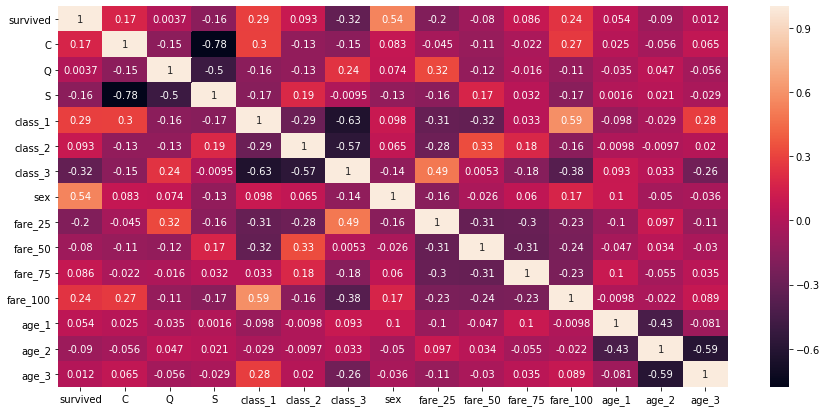

In [1011]:
plt.figure(figsize=(15,7))
sns.heatmap(data=train.corr(), annot=True)
plt.show()

In [1012]:
# Reorder the features based in ranking correlations
# now for real validation you must drop the target, here the targe=y than y=survived

train = train[["survived", "sex", "class_1", "fare_100", "C", "class_2", 
               "fare_75", "age_1", "age_3", "Q", 'fare_50', 
               'age_2', 'S', 'fare_25', 'class_3']]

train.shape, train.columns # verify if done, ok!

((891, 15),
 Index(['survived', 'sex', 'class_1', 'fare_100', 'C', 'class_2', 'fare_75',
        'age_1', 'age_3', 'Q', 'fare_50', 'age_2', 'S', 'fare_25', 'class_3'],
       dtype='object'))

In [1013]:
train['family_size'] = df_train['SibSp'] + df_train['Parch']
train.shape, train.columns

((891, 16),
 Index(['survived', 'sex', 'class_1', 'fare_100', 'C', 'class_2', 'fare_75',
        'age_1', 'age_3', 'Q', 'fare_50', 'age_2', 'S', 'fare_25', 'class_3',
        'family_size'],
       dtype='object'))

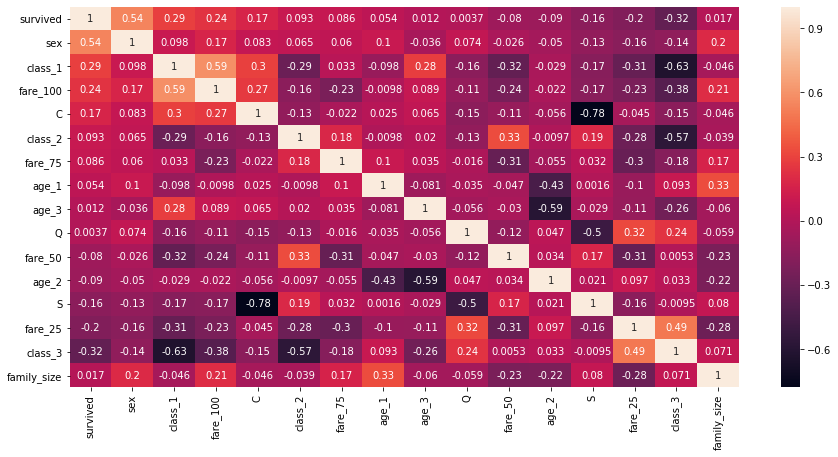

In [1014]:
plt.figure(figsize=(15,7))
sns.heatmap(data=train.corr(), annot=True)
plt.show()
# the family_size is better than the ranking, let's change the ranking and put after age_1

In [1015]:
train = train[["survived", "sex", "class_1", "fare_100", "C", "class_2", 
               "fare_75", "age_1", "family_size", "age_3", "Q", 'fare_50', 
               'age_2', 'S', 'fare_25', 'class_3']]

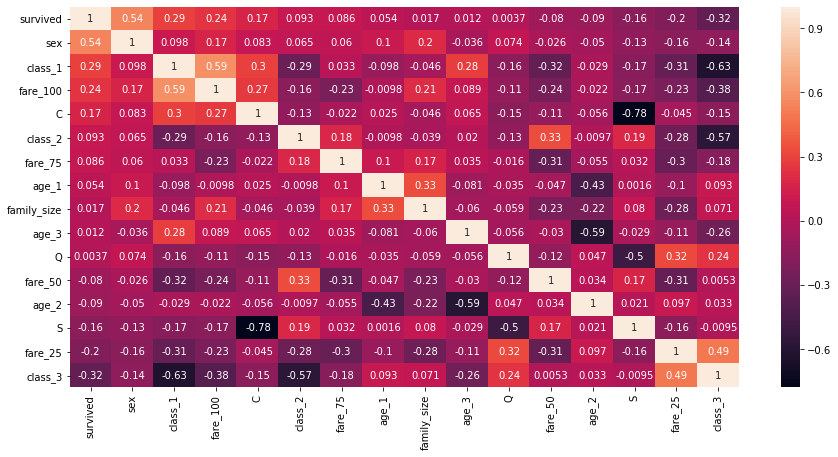

In [1016]:
plt.figure(figsize=(15,7))
sns.heatmap(data=train.corr(), annot=True)
plt.show()
# Now it's correct the ranking it's good.

In [1069]:
train.drop('survived', axis=1, inplace=True)

# Baseline

In [1070]:
X = train.sex[train.sex == 1]
y = df_train.Survived[train.sex ==1]
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.50, stratify=y)

In [1071]:
np.mean(yvalid == Xvalid)

0.7388535031847133

# Data from Test for using to test and submit

In [1072]:
test = pd.DataFrame() # creating a new dataframe structure
test['fare'] = df_test['Fare'].copy()
test['pclass'] = df_test['Pclass'].copy()
test['age'] = df_test['Age'].fillna(df_test['Age'].median()) 
dum_emb = pd.get_dummies(df_test['Embarked']).fillna('S') # transform string in number and divided in new columns
test = pd.concat([test, dum_emb], axis=1)

# You can get divided dummy from pclass, creat news columns
dum_pclass = pd.get_dummies(test['pclass'], prefix='class')
test = pd.concat([test, dum_pclass], axis=1)
#train.drop('pclass', axis=1, inplace=True)
test['sex'] = df_test['Sex'].map({'male':0, 'female':1})
# ----------------------------------------------------------------------------------------------------------------------
# I tried get dummies from Fare, but creat a lot of columns, and the score is not so good, than I created a slices
# of values until 25, 50, 75 and 100, it's mean I clustered in four clusters.

#clustering the values of fare in quartis
fare_25 = test.fare[test.fare < 7.92]
fare_50 = test.fare[(test['fare'] >= 7.92) & (test['fare'] < 14.46)]
fare_75 = test.fare[(test['fare'] >= 14.46) & (test['fare'] < 31)]
fare_100 = test.fare[test.fare > 31]

# name of features
fare_25.name, fare_50.name = 'fare_25', 'fare_50'
fare_75.name, fare_100.name = 'fare_75', 'fare_100'

# concat the series clustered with dataframe 'train'
test = pd.concat([test, fare_25], axis=1).fillna(0)
test = pd.concat([test, fare_50], axis=1).fillna(0)
test = pd.concat([test, fare_75], axis=1).fillna(0)
test = pd.concat([test, fare_100], axis=1).fillna(0)
# ----------------------------------------------------------------------------------------------------------------------
# clustered ages in three parts
age_1 = test.age[test['age'] < 15]
age_2 = test.age[(test['age'] > 14) & (test['age'] < 48)]
age_3 = test.age[test['age'] > 47]

# named features
age_1.name, age_2.name, age_3.name = 'age_1', 'age_2', 'age_3'

# concat series clustered with dataframe 'train'
test = pd.concat([test, age_1], axis=1).fillna(0)
test = pd.concat([test, age_2], axis=1).fillna(0)
test = pd.concat([test, age_3], axis=1).fillna(0)
# ----------------------------------------------------------------------------------------------------------------------
# now I'm going to drop after clustered the features
test.drop(['fare', 'pclass', 'age'], axis=1, inplace=True)
# ----------------------------------------------------------------------------------------------------------------------

test = test[["sex", "class_1", "fare_100", "C", "class_2", 
               "fare_75", "age_1", "age_3", "Q", 'fare_50', 
               'age_2', 'S', 'fare_25', 'class_3']]

# ----------------------------------------------------------------------------------------------------------------------
test['family_size'] = df_test['SibSp'] + df_test['Parch']

# ----------------------------------------------------------------------------------------------------------------------

test = test[["sex", "class_1", "fare_100", "C", "class_2", 
             "fare_75", "age_1", "family_size", "age_3", "Q", 'fare_50', 
             'age_2', 'S', 'fare_25', 'class_3']]
# ----------------------------------------------------------------------------------------------------------------------


In [1073]:
train.columns, train.shape, test.columns, test.shape

(Index(['sex', 'class_1', 'fare_100', 'C', 'class_2', 'fare_75', 'age_1',
        'family_size', 'age_3', 'Q', 'fare_50', 'age_2', 'S', 'fare_25',
        'class_3'],
       dtype='object'),
 (891, 15),
 Index(['sex', 'class_1', 'fare_100', 'C', 'class_2', 'fare_75', 'age_1',
        'family_size', 'age_3', 'Q', 'fare_50', 'age_2', 'S', 'fare_25',
        'class_3'],
       dtype='object'),
 (418, 15))

# News Features if it will be necessary

# Scaler

In [1076]:
# scaler = MinMaxScaler()
# X_train_scaler = scaler.fit_transform(train)

#### Standart Scaler

In [1075]:
stand = StandardScaler()
stand.fit(train)
XtrainScaler = stand.fit_transform(train)
XtestScaler = stand.fit_transform(test)

In [1078]:
XtestScaler.shape

(418, 15)

# Spliting Data to Train and Validation

In [1079]:
#X = train
#X = X_train_scaler
X = XtrainScaler
y = df_train['Survived']

In [1080]:
np.random.seed(0)
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.5, stratify=y)

# Model Prediction

In [1081]:
mdl = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0) # better model
mdl.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [1090]:
pred = mdl.predict(Xvalid)
proba_rf = mdl.predict_proba(Xvalid)[:, 1]

In [1093]:
print(roc_auc_score(yvalid, proba_rf), np.mean(yvalid == pred))
print(f'acc: {np.mean(yvalid == pred)*0.92}')
print(classification_report(yvalid, pred))

0.8216693248272195 0.773542600896861
acc: 0.7116591928251121
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       275
           1       0.74      0.63      0.68       171

    accuracy                           0.77       446
   macro avg       0.76      0.75      0.75       446
weighted avg       0.77      0.77      0.77       446



# Balancing class

In [479]:
# rus = RandomUnderSampler()
# Xres, yres = rus.fit_sample(Xtrain, ytrain)
# mdl.fit(Xres, yres)
# pred_balanc = mdl.predict(Xvalid)
# print(classification_report(yvalid, pred_balanc))

## Cross Validation

In [925]:
acc_list = []
roc_auc_kf = []

In [928]:
kf = KFold(3, shuffle=True, random_state=0)
for line_t, line_v in kf.split(train):
    Xtrain, Xvalid = train.iloc[line_t], train.iloc[line_v]
    ytrain, yvalid = y.iloc[line_t], y.iloc[line_v]
    
    mdl = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    mdl.fit(Xtrain, ytrain)
    
    p = mdl.predict(Xvalid)
    proba = mdl.predict_proba(Xvalid)[:, 1]
    acc_list.append(np.mean(yvalid == p))
    roc_auc_kf.append(proba)
print("acc", np.mean(acc_list))
print("roc", np.mean(roc_auc_kf))

acc 0.8181818181818181
roc 0.39685431777350966


In [930]:
print(roc_auc_kf)
print(classification_report(yvalid, p))

[array([0.97      , 0.45      , 0.16      , 0.34      , 0.83      ,
       0.0675    , 0.4       , 0.02      , 0.73      , 0.03333333,
       0.46      , 0.42      , 0.93      , 0.64      , 0.03333333,
       0.64      , 0.42      , 0.        , 0.76      , 0.38      ,
       0.05      , 0.99      , 0.25      , 0.62      , 0.56011905,
       0.32      , 0.17      , 0.78      , 0.27      , 0.12      ,
       0.05416667, 0.        , 0.        , 0.64      , 0.53      ,
       0.61      , 0.        , 0.42666667, 0.        , 0.77      ,
       0.03211219, 0.42      , 0.2       , 0.23      , 0.        ,
       0.88      , 0.84      , 0.48      , 0.09883333, 0.22      ,
       0.03      , 0.        , 0.91      , 0.04      , 0.57      ,
       0.27042857, 0.07666667, 0.55      , 0.06      , 0.24      ,
       0.96      , 0.12163864, 0.08      , 0.155     , 0.18583333,
       0.        , 0.07646898, 0.99      , 0.1065    , 0.98      ,
       0.33921429, 0.49916667, 0.03      , 0.30920238, 0.32  

# Boosting

In [982]:
# First of all, I'm going to try the GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.007, max_depth=2, max_features=2, random_state=0)
gb.fit(Xtrain, ytrain)

predgb = gb.predict(Xvalid)
probagb = gb.predict_proba(Xvalid)[:, 1]
pred = gb.predict(test)

In [983]:
print(classification_report(yvalid, predgb))
print(precision_score(yvalid, predgb))
print(f'roc_auc_score: {roc_auc_score(yvalid, probagb)}')
# lr: 0.05 = precision: 0.80 || lr: 0.01 = prec:0.85

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       221
           1       0.78      0.70      0.74       136

    accuracy                           0.81       357
   macro avg       0.80      0.79      0.79       357
weighted avg       0.81      0.81      0.81       357

0.7786885245901639
roc_auc_score: 0.8727541921746074


In [985]:
np.mean(predgb == yvalid)*0.92856

0.7516914285714287

In [806]:
yscore = gb.decision_function(Xvalid)
xcurve, ycurve, _ = roc_curve(yvalid, yscore)
roc_auc_gb = auc(xcurve, ycurve)

print(roc_auc_gb)

0.8848214285714285


In [743]:
learning_rate = 0.001
prec_list = {}
roc_list = {}
while learning_rate < 1:
    gb = GradientBoostingClassifier(n_estimators=1000, learning_rate=learning_rate, max_depth=2, max_features=2, random_state=0)
    gb.fit(Xtrain, ytrain)
    
    pred_gb = gb.predict(Xvalid)
    proba = gb.predict_proba(Xvalid)[:, 1]
    prec_sc = precision_score(yvalid, pred_gb)
    roc_auc = roc_auc_score(yvalid, proba)
    #print(f' Precision learnin_r {learning_rate:.3f} :{prec_sc}')
    
    learning_rate += 0.001
    prec_list[prec_sc] = learning_rate
    roc_list[roc_auc] = learning_rate

    
    #proba_gb = gb.predict_proba(Xvalid)[:, 1]
    #print(f'ROC_AUC: {roc_auc_score(yvalid, proba_gb)}')
    #print('--'*20)

In [748]:
max_precision = max(prec_list)
max_roc_auc = max(roc_list)

In [762]:
print(f'prec: {max_precision} : learning_rate: {prec_list.get(max_precision)}')
print(f'prec: {max_roc_auc} : learning_rate: {prec_list.get(max_roc_auc)}')

prec: 0.9736842105263158 : learning_rate: 0.002
prec: 0.8848214285714285 : learning_rate: None


# LGBMClassifier

In [986]:
mdl = LGBMClassifier(random_state=0, learning_rate=0.007, n_estimators=1000)
mdl.fit(Xtrain, ytrain)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.007, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [987]:
proba_lgbm = mdl.predict_proba(Xvalid)[:, 1]
pred_lgbm = mdl.predict(Xvalid)
pred = mdl.predict(test)
print(f'acc: {np.mean(pred_lgbm == yvalid)*0.92}')
print(f'Roc_auc_score: {roc_auc_score(yvalid, proba_lgbm)}')
print(classification_report(yvalid, pred_lgbm))

acc: 0.7628011204481794
Roc_auc_score: 0.8801736758051637
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       221
           1       0.83      0.70      0.76       136

    accuracy                           0.83       357
   macro avg       0.83      0.80      0.81       357
weighted avg       0.83      0.83      0.83       357



#### Tunning model LGBM

In [900]:
def model_training(parameters):
    learning_rate = parameters[0]
    num_leaves = parameters[1]
    min_child_samples = parameters[2]
    subsample = parameters[3]
    colsample_bytree = parameters[4]
    
    #print(parameters)
    
    mdl = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, 
                         min_child_samples=min_child_samples, subsample=subsample, 
                         colsample_bytree=colsample_bytree, random_state=1, subsample_freq=5,
                        n_estimators=400)
    mdl.fit(Xtrain, ytrain)
    
    #predictions and probality
    prob = mdl.predict_proba(Xvalid)[:, 1]
    pred_lgbm = mdl.predict(Xvalid)
    
    # metrics
    return -roc_auc_score(yvalid, prob), 

    
space = [(1e-3, 1e-1, 'log-uniform'),  # learning_rates
          (2, 150),                    # num_leaves
          (1, 120),                    # min_child_samples
          (0.01, 1.0),                 # subsamples
          (0.1, 1.0)]                  # colsample_bytree

results = dummy_minimize(model_training, space, random_state=0, n_calls=200, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1750
Function value obtained: -0.8690
Current minimum: -0.8690
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0818
Function value obtained: -0.5000
Current minimum: -0.8690
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1022
Function value obtained: -0.8498
Current minimum: -0.8690
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3385
Function value obtained: -0.8688
Current minimum: -0.8690
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1882
Function value obtained: -0.8590
Current minimum: -0.8690
Iteration No: 6 started. 

In [901]:
model_training(results.x)

-0.8921428571428572

In [995]:
parameters = results.x
    
learning_rate = parameters[0]
num_leaves = parameters[1]
min_child_samples = parameters[2]
subsample = parameters[3]
colsample_bytree = parameters[4]

mdl = LGBMClassifier(learning_rate=learning_rate, 
                     num_leaves=num_leaves, 
                     min_child_samples=min_child_samples,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     random_state=1, subsample_freq=5,
                     n_estimators=400
                    )

mdl.fit(Xtrain, ytrain)
pred_gbm = mdl.predict(Xvalid)
proba_lgbm = mdl.predict_proba(Xvalid)[:, 1]
pred = mdl.predict(XtestScaler)

print(f'acc: {np.mean(pred_gbm == yvalid)*0.92}')
print(classification_report(yvalid, pred_gbm))
print(roc_auc_score(yvalid, proba_lgbm))

acc: 0.7473389355742297
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       221
           1       0.91      0.57      0.70       136

    accuracy                           0.81       357
   macro avg       0.84      0.76      0.78       357
weighted avg       0.83      0.81      0.80       357

0.880889007186585


# bayesian optimazetion

In [919]:
results_gp = gp_minimize(model_training, space, n_calls=30, n_random_starts=10, verbose=1, random_state=1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5194
Function value obtained: -0.8659
Current minimum: -0.8659
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2097
Function value obtained: -0.8689
Current minimum: -0.8689
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1218
Function value obtained: -0.8324
Current minimum: -0.8689
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2891
Function value obtained: -0.8593
Current minimum: -0.8689
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.4927
Function value obtained: -0.8714
Current minimum: -0.8714
Iteration No: 6 started. 

In [993]:
model_training(results_gp.x)

-0.876131221719457

In [920]:
plt.figure(figsize=(15,18))
plot_convergence(results, results_gp, results_gb)

NameError: name 'results_gb' is not defined

<Figure size 1080x1296 with 0 Axes>

# Metrics

In [446]:
# this metrics are used to classification                       #   01  -   02  -   03  -  04   -  05   -  06   -  07   -   08    -  09
#mean = np.mean(pred == yvalid)*100                             # 80.94 - 81.17 - 80.94 - 79.60 - 80.94 - 78.92 - 81.16 - 81.3901 - 82.5112
#msle = 100-(np.sqrt(mean_squared_log_error(yvalid, pred))*100) # 69.74 - 69.92 - 68.69 - 68.69 - 69.74 - 68.18 - 69.92 - 70.0982 - 71.0128
#f1 = f1_score(yvalid, pred)                                    # 0.733 - 0.737 - 0.720 - 0.720 - 0.727 - 0.713 - 0.745 - 0.750   - 0.7664
#roc = roc_auc_score(yvalid, pred)                              # 0.789 - 0.793 - 0.780 - 0.780 - 0.785 - 0.774 - 0.800 - 0.803   - 0.8166

In [315]:
prec = precision_score(yvalid, pred)                            # 0.750 - 0.752 - 0.722 - 0.722 - 0.763 - 0.710 - 0.736 - 0.735   - 0.7485

In [445]:
print(classification_report(yvalid, pred))

ValueError: Found input variables with inconsistent numbers of samples: [79, 446]

# Submission

In [1089]:
#sub = pd.Series(pred, index=df_test['PassengerId'], name='Survived')

sub = pd.DataFrame({
    'PassengerId':df_test['PassengerId'],
    'Survived':pred
})
sub.to_csv("sub_290320_rf_I.csv", index=False) # f1_score is better to validation in titanic kaggle

# KAGGLE= 0.74641 | precision=0.734 |F1_SCORE = 0.7340 | MLD.SCORE = 0.9842 | roc_auc_score(proba) = 0.8648 | roc_auc_score(pred) = 0.7903